In [1]:
import nltk
import ssl 

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

    nltk.download('stopwords')

    nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/joselopez/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/joselopez/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


## Importamos las librerías

In [2]:
import re
import numpy as np
import pandas as pd
from pprint import pprint
import string
import unidecode

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models #gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
np.random.seed(21)

In [3]:
pd.set_option('display.max_columns', None)


In [4]:
from nltk.corpus import stopwords
stop_words = stopwords.words('spanish')

In [5]:
df=pd.read_csv('csv0.csv', sep='-',header=None, names=['id','text'])

In [6]:
df.head()

,id,text
0,1401047081121353728,@dulcema201 @BronstonRaqsa02 Protocolo de COVI...
1,1258159310162595843,"#COVID19 #QuedateEnCasa en Morelia Centro, Mor..."
2,1272748988626862082,México va en en aumento con el #Covid_19. Tal ...
3,1349385638722883585,@sororavirus Creo en todo y nada. 💜
4,1360615587114844161,"@GobiernoMX había prometido 389,000, llegarán ..."


In [7]:
df=df.loc[~df['text'].isna()]


In [8]:
df=df.loc[df.text.drop_duplicates().index]
original=df['text'].to_list()

## Función que indentifica y extrae hashtags y menciones

In [9]:
def get_mention(text):
    return re.findall(r'(@+[a-zA-Z0-9(_)]{1,})', text)
def get_hash(text):
    return re.findall(r'(#+[a-zA-Z0-9(_)]{1,})', text)
def rem_mention(text):
    return re.sub(r'(@+[a-zA-Z0-9(_)]{1,})',' ', text)
def rem_hash(text):
    return re.sub(r'(#+[a-zA-Z0-9(_)]{1,})',' ', text)


In [10]:
df['mention']=df['text'].apply(get_mention)
df['hash']=df['text'].apply(get_hash)

In [11]:
#df['text']=df['text'].apply(rem_hash)
df['text']=df['text'].apply(rem_mention)


In [12]:
df.sample(5)

,id,text,mention,hash
3244,1250582529649803264,Rasa en la Noticia al aire desde casa 🏠#SLP 94...,[],"[#SLP, #Qu, #Radio, #Noticias, #AlAire]"
38,1316212646295855104,Vagones que se descarrilan.Pipas que no cump...,[@m_ebrard],[]
4639,1295555339434078208,Sábado 29 de agosto tendremos asombrosa acampa...,[],[]
2005,1270184766139019270,Resultó ser un éxito la vacuna de benzetacil +...,[],[]
984,1252583419009216512,Jajajaja #NoMames sin #Chayote y con #Bo...,"[@jorgeberry, @skyaquaklin, @lopezobrador_]","[#NoMames, #Chayote, #Borolavirus]"


## Extraemos los textos en una lista

In [13]:

docs=df['text'].to_list()

In [14]:
docs[0]

'    Protocolo de COVID !!!!'

In [15]:
len(docs)

4995

# 1. Preprocesamiento
## 1.1 Removemos enlaces, puntuación y caracteres especiales

In [16]:

def remove_Htt(text):
    return re.sub(r' https://*\S*', "", text)
    
def remove_punctuation ( text ):
    return re.sub('[%s]' % re.escape(string.punctuation), ' ', text)

def deEmojify(text):
    return unidecode.unidecode(text)



In [17]:
docs=[sent.lower() for sent in docs]


In [18]:
docs=[remove_punctuation(remove_Htt(i.lower())) for i in docs]
docs=[remove_punctuation(remove_punctuation(i.lower())) for i in docs]
docs=[remove_punctuation(deEmojify(i.lower())) for i in docs]

In [19]:
data = [re.sub('\S*@\S*\s?', '', sent) for sent in docs]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

In [20]:
data[:3]

[' protocolo de covid ',
 ' covid19 quedateencasa en morelia centro morelia',
 'mexico va en en aumento con el covid 19 tal vez no tengamos la estabilidad de europa o estados unidos para mantener 120 dias en paro total pero podemos ser precavidos al usar la sanadistancia cubrebocas y caretas al ir a trabajar fuerzamexico']

# 2. Tokenizamos
Este paso consiste en descomponer un texto lo más posible, en este caso, palabra por palabra

In [21]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))



In [22]:
data_words[:2]

[['protocolo', 'de', 'covid'],
 ['covid', 'quedateencasa', 'en', 'morelia', 'centro', 'morelia']]

# 3. Bigramas y trigramas
Construimos modelos para los bigramas y trigramas, extraemos oraciones con mayor sentido: ie: ['estados','unidos']->['estados_unidos']
De esta manera, podemos aprender e identificar pares o tercias de términos que aparecen juntos aportandole mayor sentido a nuestro análisis.

In [23]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words])  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)



In [24]:
print(trigram_mod[bigram_mod[data_words[0]]])

['protocolo', 'de', 'covid']


## 3.1 Stop words
Antes de pasar a bigramas debemos eliminar los stop-words [el, la, a, los,...etc] ya que no aportan información y no afectan el contexto, y sin embargo suelen ser los tokens más comunes ya que son utilizados para conectar palabras como sujetos-adjetivos, etc.

In [25]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

# 4. Lematización
Podíamos usar dos opciones, lematizar o stemming, sin embargo, prefiero en mi caso lematizar, ya que la lematización hace un análisis de la raíz de la palabra, de esta manera identificamos no sólo la raíz, sino también si es un verbo, adjetivo, etc. A comparación del stemming que trata de reducir a raices eliminado sufijos, donde muchas veces no tienen sentido, sin embargo suele ser más rápido.

In [26]:
data_words_nostops = remove_stopwords(data_words)

data_words_bigrams = make_bigrams(data_words_nostops)


nlp = spacy.load('es_core_news_sm', disable=['parser', 'ner'])

data_lemmatized = lemmatization(data_words_bigrams)



In [53]:
print(data_lemmatized[:3])

[[], ['quedateencasar', 'morelio', 'centro'], ['mexico', 'ir', 'estabilidad', 'mantener', 'paro', 'total', 'precavir', 'usar', 'sanadistancia', 'cubreboca', 'careta', 'trabajar', 'fuerzamexico']]


## 4.1 Matriz termino-frecuencia
Creamos nuestro corpus, que son todos los textos que tenemos, de estos creamos una matriz término-frecuencia, el cual nos cuenta cuántas veces aparece una palabra-bigrama.

In [28]:
id2word = corpora.Dictionary(data_lemmatized)
#corpus
texts = data_lemmatized
#matriz
corpus = [id2word.doc2bow(text) for text in texts]

print(corpus[:1])

[[]]


In [29]:
data[0]

' protocolo de covid '

In [30]:
corpus

[[],
 [(0, 1), (1, 1), (2, 1)],
 [(3, 1),
  (4, 1),
  (5, 1),
  (6, 1),
  (7, 1),
  (8, 1),
  (9, 1),
  (10, 1),
  (11, 1),
  (12, 1),
  (13, 1),
  (14, 1),
  (15, 1)],
 [(16, 1)],
 [(17, 1), (18, 1), (19, 1)],
 [(20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1)],
 [(26, 1)],
 [(27, 1), (28, 1), (29, 1), (30, 1), (31, 1)],
 [(32, 1),
  (33, 1),
  (34, 1),
  (35, 1),
  (36, 1),
  (37, 1),
  (38, 1),
  (39, 1),
  (40, 1),
  (41, 1),
  (42, 1)],
 [(13, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1)],
 [(49, 1), (50, 1)],
 [(51, 1)],
 [(52, 1),
  (53, 1),
  (54, 1),
  (55, 1),
  (56, 1),
  (57, 1),
  (58, 1),
  (59, 1),
  (60, 1)],
 [(61, 1)],
 [(62, 1),
  (63, 1),
  (64, 1),
  (65, 1),
  (66, 1),
  (67, 1),
  (68, 1),
  (69, 1),
  (70, 1),
  (71, 1),
  (72, 1)],
 [(27, 1),
  (49, 1),
  (73, 1),
  (74, 1),
  (75, 1),
  (76, 1),
  (77, 1),
  (78, 1),
  (79, 1)],
 [(52, 1),
  (75, 3),
  (80, 1),
  (81, 1),
  (82, 1),
  (83, 1),
  (84, 1),
  (85, 1),
  (86, 1),
  (87, 1),
  (88, 

In [31]:
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[-1:]]

[[('llegar', 1),
  ('terminar', 1),
  ('solo', 1),
  ('partir', 1),
  ('integrante', 1),
  ('calderon', 1),
  ('sexenio', 1),
  ('colocar', 1),
  ('corta', 1)]]

In [54]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=4, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [55]:
print(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0, '0.017*"decir" + 0.016*"ver" + 0.013*"gente" + 0.012*"mas" + 0.010*"crisis" + 0.010*"querer" + 0.008*"salir" + 0.008*"asi" + 0.007*"esperar" + 0.007*"prueba"'), (1, '0.026*"quedateencasar" + 0.021*"vacuna" + 0.017*"hoy" + 0.015*"dar" + 0.013*"persona" + 0.011*"salud" + 0.011*"bien" + 0.009*"virus" + 0.008*"cuarentenar" + 0.007*"primero"'), (2, '0.025*"mexico" + 0.025*"hacer" + 0.018*"cuarentena" + 0.015*"pandemiar" + 0.012*"ano" + 0.011*"solo" + 0.011*"mejor" + 0.009*"creer" + 0.008*"saber" + 0.008*"tiempo"'), (3, '0.016*"seguir" + 0.015*"contagio" + 0.013*"pandemia" + 0.012*"caso" + 0.011*"coronavirus" + 0.011*"ahora" + 0.010*"covid_mx" + 0.008*"medida" + 0.008*"vivir" + 0.007*"dia"')]


In [56]:
for i in lda_model.print_topics():
    print("\n\nMost important words in topic:", i)



Most important words in topic: (0, '0.017*"decir" + 0.016*"ver" + 0.013*"gente" + 0.012*"mas" + 0.010*"crisis" + 0.010*"querer" + 0.008*"salir" + 0.008*"asi" + 0.007*"esperar" + 0.007*"prueba"')


Most important words in topic: (1, '0.026*"quedateencasar" + 0.021*"vacuna" + 0.017*"hoy" + 0.015*"dar" + 0.013*"persona" + 0.011*"salud" + 0.011*"bien" + 0.009*"virus" + 0.008*"cuarentenar" + 0.007*"primero"')


Most important words in topic: (2, '0.025*"mexico" + 0.025*"hacer" + 0.018*"cuarentena" + 0.015*"pandemiar" + 0.012*"ano" + 0.011*"solo" + 0.011*"mejor" + 0.009*"creer" + 0.008*"saber" + 0.008*"tiempo"')


Most important words in topic: (3, '0.016*"seguir" + 0.015*"contagio" + 0.013*"pandemia" + 0.012*"caso" + 0.011*"coronavirus" + 0.011*"ahora" + 0.010*"covid_mx" + 0.008*"medida" + 0.008*"vivir" + 0.007*"dia"')


In [57]:
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -9.214175352286574

Coherence Score:  0.26421315109768645


In [58]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis

/Users/joselopez/opt/miniconda3/envs/mlp/lib/python3.7/site-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.186324  0.138861       1        1  29.055363
1      0.204118  0.109780       2        1  27.562470
0     -0.018344 -0.190639       3        1  24.253373
3      0.000550 -0.058002       4        1  19.128795, topic_info=                Term        Freq       Total Category  logprob  loglift
2     quedateencasar  310.000000  310.000000  Default  30.0000  30.0000
9             mexico  319.000000  319.000000  Default  29.0000  29.0000
75             hacer  310.000000  310.000000  Default  28.0000  28.0000
249           vacuna  257.000000  257.000000  Default  27.0000  27.0000
216       cuarentena  226.000000  226.000000  Default  26.0000  26.0000
...              ...         ...         ...      ...      ...      ...
2946           junio   28.273834   28.954541   Topic4  -5.6848   1.6302
1600          vacuno   27.145544   27.799611   Topic4  -5.7255   1.6302
1026           sumar   25.629193   26.283135   Topic4  -5.7830   1.6288
1385       municipio   25.171815   25.841649   Topic4  -5.8010   1.6277
282            ahora   90.107426   93.923613   Topic4  -4.5257   1.6125

[153 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
49        1  0.985610   acabar
282       2  0.031941    ahora
282       4  0.958225    ahora
73        1  0.989032    amigo
393       1  0.992893      ano
...     ...       ...      ...
514       2  0.981833   verdad
228       2  0.994536     vida
1117      4  0.962057  viernes
25        2  0.993311    virus
640       4  0.993426    vivir

[126 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 1, 4])

In [59]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    sent_topics_df = pd.DataFrame()

    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_words_nostops)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,2.0,0.2907,"mexico, hacer, cuarentena, pandemiar, ano, sol...","[protocolo, covid]"
1,1,2.0,0.3094,"mexico, hacer, cuarentena, pandemiar, ano, sol...","[covid, quedateencasa, morelia, centro, morelia]"
2,2,3.0,0.3689,"seguir, contagio, pandemia, caso, coronavirus,...","[mexico, va, aumento, covid, tal, vez, estabil..."
3,3,2.0,0.3249,"mexico, hacer, cuarentena, pandemiar, ano, sol...",[creo]
4,4,2.0,0.3043,"mexico, hacer, cuarentena, pandemiar, ano, sol...","[habia, prometido, llegaran, covid, vacunacion..."
5,5,1.0,0.2917,"quedateencasar, vacuna, hoy, dar, persona, sal...","[the, demons, are, the, politicians, and, idio..."
6,6,2.0,0.2856,"mexico, hacer, cuarentena, pandemiar, ano, sol...","[vacunacion, tonala]"
7,7,0.0,0.2725,"decir, ver, gente, mas, crisis, querer, salir,...","[cierto, dice, si, tomando, pandemia, serio]"
8,8,1.0,0.3907,"quedateencasar, vacuna, hoy, dar, persona, sal...","[participa, familia, entretenida, actividad, m..."
9,9,3.0,0.3662,"seguir, contagio, pandemia, caso, coronavirus,...","[nacional, casos, positivos, covid, confirmado..."


In [60]:
df_dominant_topic['OriginalComment']=original

In [61]:
len(docs)

4995

In [62]:
df_dominant_topic.sample(5)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,OriginalComment
1506,1506,2.0,0.3680,"mexico, hacer, cuarentena, pandemiar, ano, sol...","[si, covid, todas, formas, estaria, valiendo, ...",Si no hubiera COVID; de todas formas estaría v...
3895,3895,1.0,0.3014,"quedateencasar, vacuna, hoy, dar, persona, sal...","[virgencita, piso, metro, hidalgo, plis, termi...",Virgencita del piso del metro Hidalgo plis que...
4584,4584,1.0,0.3428,"quedateencasar, vacuna, hoy, dar, persona, sal...","[vida, tiempos, cuarentena]",Mi vida en tiempos de cuarentena
1269,1269,1.0,0.4370,"quedateencasar, vacuna, hoy, dar, persona, sal...","[estimado, companero, desarrollador, invitamos...","📢📢📢 Estimado compañero desarrollador, te invit..."
4827,4827,1.0,0.3423,"quedateencasar, vacuna, hoy, dar, persona, sal...","[consigue, trabajo, cuarentena]",@DagninoDamar ¿Como se consigue trabajo en Cua...


In [63]:
df_dominant_topic['mention']=df['mention'].values
df_dominant_topic['hash']=df['hash'].values

In [64]:
df_dominant_topic

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,OriginalComment,mention,hash
0,0,2.0,0.2907,"mexico, hacer, cuarentena, pandemiar, ano, sol...","[protocolo, covid]",@dulcema201 @BronstonRaqsa02 Protocolo de COVI...,"[@dulcema201, @BronstonRaqsa02]",[]
1,1,2.0,0.3094,"mexico, hacer, cuarentena, pandemiar, ano, sol...","[covid, quedateencasa, morelia, centro, morelia]","#COVID19 #QuedateEnCasa en Morelia Centro, Mor...",[],"[#COVID19, #QuedateEnCasa]"
2,2,3.0,0.3689,"seguir, contagio, pandemia, caso, coronavirus,...","[mexico, va, aumento, covid, tal, vez, estabil...",México va en en aumento con el #Covid_19. Tal ...,[],"[#Covid_19, #SanaDistancia, #cubrebocas, #fuer..."
3,3,2.0,0.3249,"mexico, hacer, cuarentena, pandemiar, ano, sol...",[creo],@sororavirus Creo en todo y nada. 💜,[@sororavirus],[]
4,4,2.0,0.3043,"mexico, hacer, cuarentena, pandemiar, ano, sol...","[habia, prometido, llegaran, covid, vacunacion...","@GobiernoMX había prometido 389,000, llegarán ...","[@GobiernoMX, @nuevoleon]","[#COVID19, #vacunacioncovid19]"
...,...,...,...,...,...,...,...,...
4990,4990,1.0,0.3582,"quedateencasar, vacuna, hoy, dar, persona, sal...","[correccion, color, clienta, despues, larga, c...",#Corrección de #Color en clienta después de un...,[],"[#Correcci, #Color, #Estamos, #ordenes, #cita,..."
4991,4991,0.0,0.2965,"decir, ver, gente, mas, crisis, querer, salir,...","[covid, psicologico, veces, mes]",ya tuve covid psicológico como 7 veces en el m...,[],[]
4992,4992,1.0,0.3134,"quedateencasar, vacuna, hoy, dar, persona, sal...","[tapatios, dijeron, vacunas, covid, amp, regre...",360 Tapatíos Dijeron #36 Vacunas Covid &amp; R...,[],"[#36, #RegresoAClases, #Mexico, #RegresoAClase..."
4993,4993,2.0,0.2908,"mexico, hacer, cuarentena, pandemiar, ano, sol...","[tener, base, datos, podria, permitir, registr...",Tener una base de datos podría permitir regist...,[],[]


In [65]:
df_dominant_topic.groupby('Dominant_Topic').count()

,Document_No,Topic_Perc_Contrib,Keywords,Text,OriginalComment,mention,hash
Dominant_Topic,,,,,,,
0.0,855,855,855,855,855,855,855
1.0,1484,1484,1484,1484,1484,1484,1484
2.0,2313,2313,2313,2313,2313,2313,2313
3.0,343,343,343,343,343,343,343


## identificacion de tópicos
1 Parece hablar de Covid pero con crítica al gobierno

In [70]:
df_dominant_topic.query("Dominant_Topic==1")[['Keywords','OriginalComment']].sample(5).values

array([['quedateencasar, vacuna, hoy, dar, persona, salud, bien, virus, cuarentenar, primero',
        'Ya estuvo. Vacuna única dosis.Vamos a retornar a la nueva normalidad y a seguirnos cuidando.#elmundocontraunvirus #VacunaCOVID19 #CanSino https://t.co/bDRBm1Ia8y'],
       ['quedateencasar, vacuna, hoy, dar, persona, salud, bien, virus, cuarentenar, primero',
        '@LuisCardenasMx @manuelandrade65 @lopezobrador_ @lopezobrador_ no tiene Covid. Es táctica para victimizarse y aprovecharse de la sensibilidad del pueblo. Si está infectado, habría que pedirle al virus que haga un favor a la patria y lo obligue a dejar la presidencia por motivos de salud o que lo mande al mas allá...'],
       ['quedateencasar, vacuna, hoy, dar, persona, salud, bien, virus, cuarentenar, primero',
        'Así como lopez se encierra en su palacio. Para evitar que los ciudadanos lo molesten; ASÍ QUIEREN hacer los PSEUDO secretario y subsecretario de SALUD, cerrando oficinas para no darse por enterados de l

### 2. Habla de covid pero de opiniones personales, planes, gustos, bromas, etc

In [74]:
df_dominant_topic.query("Dominant_Topic==2")[['OriginalComment']].sample(5).values

array([['COVID PRESIDENT ELECTION'],
       ['Poniendo al vicepandemias en su sitio.Llámame facha..'],
       ['#susanadistancia en Tabasco, Mexico https://t.co/VFn7A8ECPk'],
       ['Urge el test de BuzzFeed para saber qué cepa del COVID soy.'],
       ['La cuarentena me da muchas ganas de tener un gatito nose si este listo para ser mamá o papa']],
      dtype=object)

### 3. Critica al gobierno estatal por pandemia

In [75]:
df_dominant_topic.query("Dominant_Topic==3")[['OriginalComment']].sample(5).values

array([['#COVID19NL  #COVID2019mx#mty 12 de  julio  202018744 casos confirmados en #NuevoLeon, 677 casos mas que ayer.  599 fallecidos en total, 17 + que ayer.Pacientes hospitalizados  1230Pacientes recuperados 11,219 #CoronavirusMx#COVID__19'],
       ['Que el @Gobierno_Tab busque asesoría de la @SSalud_mx, a fin de enfrentar la crisis del #coronavirus en #Tabasco, propuso el diputado del @PRITabasco, Nicolás Bellizia Aboaf. https://t.co/aym2P8EAxk'],
       ['El Tren de Pamela#FelizViernes#ViernesDeGanarSeguidores #ViernesMusicales #BuenosDias#QuedateEnCasa#Junio2020#ElTrenDePamela#Mexico#SiguemeYTeSigo#YouTuber#ViralVideos#BreakingNews#ULTIMAHORA#Chile#ElRastas#Instagram#YouTubeMusic#Viralhttps://t.co/ZcwR0Euban'],
       ['Cuando te acostumbras a comer mierda @lopezobrador_ llega el momento en que ya no te sabe... tú gabinete no te va a dejar ponerte un cubrebocas. Más de 40 mil por pandemia y muchos más por violencia y tu con chistes estúpidos. Eres idiota'],
       ['Cuántos ya n

### 0. Empleos y covid, servicios

In [81]:
df_dominant_topic.query("Dominant_Topic==0")[['OriginalComment']].sample(5).values

array([['Habitantes de colonias populares en el abandono tras la perdida de sus empleos ante esta contingencia ocasionada por el COVID-19, el alcalde Enrique Fernández Peredo prometio apoyarnos y no llega la ayuda. #CoatepecEnElAbandono https://t.co/NXMnl9yI8r'],
       ['#OposicionUnida #Kartush #DondeEstanLasVacunas #NohayGobierno #25MesesSinResultados #AtoleConElDedo #TransformacionDe4Ta #FueraMonrealDelSenado #MentirasDeCuarta #YaCholeCulparAlPasado #UnVioladorNoSeraGobernador #ApagonAMorena #NiUnVotoAMorena #LopesInfodemico #CarcelOjosDeSapo'],
       ['@AnyluBendicion @samuel_garcias El está tomando Susana distancia para evitar la propagación 🙄🙄🙄🙄 charlatan.'],
       ['#MéxicoTeReconoceMaestro 🇲🇽✅#GraciasMaestroPor estar en la primera línea por la educación ante pandemia #coronavirus #COVID19 🦠 Adversidad no significa distancia #AprendeEnCasa 🏡👉#15deMayo 🗓️ #DíadelMaestro 👩\u200d🏫👨\u200d🏫#BuenJueves #JuntosContraElCovid Ecatepec #NuevaNormalidad https://t.co/obtV8681XZ'],
      

In [82]:
df_dominant_topic.loc[df_dominant_topic['Keywords'].str.contains('mexico')]

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,OriginalComment,mention,hash
0,0,2.0,0.2907,"mexico, hacer, cuarentena, pandemiar, ano, sol...","[protocolo, covid]",@dulcema201 @BronstonRaqsa02 Protocolo de COVI...,"[@dulcema201, @BronstonRaqsa02]",[]
1,1,2.0,0.3094,"mexico, hacer, cuarentena, pandemiar, ano, sol...","[covid, quedateencasa, morelia, centro, morelia]","#COVID19 #QuedateEnCasa en Morelia Centro, Mor...",[],"[#COVID19, #QuedateEnCasa]"
3,3,2.0,0.3249,"mexico, hacer, cuarentena, pandemiar, ano, sol...",[creo],@sororavirus Creo en todo y nada. 💜,[@sororavirus],[]
4,4,2.0,0.3043,"mexico, hacer, cuarentena, pandemiar, ano, sol...","[habia, prometido, llegaran, covid, vacunacion...","@GobiernoMX había prometido 389,000, llegarán ...","[@GobiernoMX, @nuevoleon]","[#COVID19, #vacunacioncovid19]"
6,6,2.0,0.2856,"mexico, hacer, cuarentena, pandemiar, ano, sol...","[vacunacion, tonala]",Vacunación en Tonalá,[],[]
...,...,...,...,...,...,...,...,...
4984,4984,2.0,0.3197,"mexico, hacer, cuarentena, pandemiar, ano, sol...","[easter, sunday, in, times, of, covid, domingo...",Easter Sunday in times of COVID-19 /Domingo de...,[],[]
4986,4986,2.0,0.3657,"mexico, hacer, cuarentena, pandemiar, ano, sol...","[doblemente, embarazada, pelicula, perfecta, d...",“Doblemente embarazada” es la película perfect...,[],[]
4989,4989,2.0,0.3680,"mexico, hacer, cuarentena, pandemiar, ano, sol...","[mejores, personas, pasado, cuarentena]",Eres de las mejores personas que me a pasado e...,[],[]
4993,4993,2.0,0.2908,"mexico, hacer, cuarentena, pandemiar, ano, sol...","[tener, base, datos, podria, permitir, registr...",Tener una base de datos podría permitir regist...,[],[]


In [83]:
df_dominant_topic.Keywords.drop_duplicates()

0    mexico, hacer, cuarentena, pandemiar, ano, sol...
2    seguir, contagio, pandemia, caso, coronavirus,...
5    quedateencasar, vacuna, hoy, dar, persona, sal...
7    decir, ver, gente, mas, crisis, querer, salir,...
Name: Keywords, dtype: object

In [85]:
file=pd.merge(df_dominant_topic.groupby(by='Dominant_Topic').mean(), df_dominant_topic[['Dominant_Topic','Keywords']].groupby('Dominant_Topic').first(),
        left_index=True, right_index=True)

In [86]:
file

,Document_No,Topic_Perc_Contrib,Keywords
Dominant_Topic,,,
0.0,2452.720468,0.329547,"decir, ver, gente, mas, crisis, querer, salir,..."
1.0,2473.996631,0.340667,"quedateencasar, vacuna, hoy, dar, persona, sal..."
2.0,2552.990056,0.335969,"mexico, hacer, cuarentena, pandemiar, ano, sol..."
3.0,2329.335277,0.323136,"seguir, contagio, pandemia, caso, coronavirus,..."


In [90]:
df_dominant_topic.loc[df_dominant_topic['Dominant_Topic']==0,'Dominant_Topic']='Servicios'
df_dominant_topic.loc[df_dominant_topic['Dominant_Topic']==1,'Dominant_Topic']='Gobierno federal'
df_dominant_topic.loc[df_dominant_topic['Dominant_Topic']==2,'Dominant_Topic']='Vida cotidiana'
df_dominant_topic.loc[df_dominant_topic['Dominant_Topic']==3,'Dominant_Topic']='Gobierno estatal'

<AxesSubplot:xlabel='Dominant_Topic'>

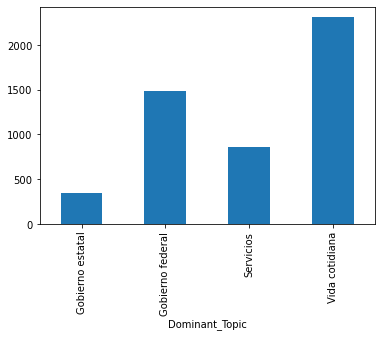

In [94]:
df_dominant_topic.groupby('Dominant_Topic').count()['Text'].plot(kind='bar')